In [1]:
import requests
import numpy as np
import json
import pandas as pd
import ibmseti
import collections
import scipy.io
import matplotlib.pyplot as plt
import commonutils as cu

Using TensorFlow backend.


In [2]:
r = requests.get('https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b/simsignals_files/public_list_headers_3april_2017.txt')

In [3]:
fileList = r.text.split('\n')[:-1]
fileListJSON = [json.loads(entry) for entry in fileList]
fileListJSON[0]

{u'file_name': u'00069203-0824-4136-9c99-b9f68672f23d.dat',
 u'signal_classification': u'squigglesquarepulsednarrowband',
 u'uuid': u'00069203-0824-4136-9c99-b9f68672f23d'}

## Code for downloading a subset of data (skip if not required)

In [4]:
# Taking a subset of signals to download and play around with
subset = dict.fromkeys(list(np.unique([ str(file['signal_classification']) for file in fileListJSON])))
for key in subset.keys(): subset[key] = []
nSignals = 10
i = 0
while any( [len(v)<nSignals for v in subset.values()] ):
    current = (str(fileListJSON[i]['signal_classification']),str(fileListJSON[i]['file_name']))
    if len(subset[current[0]])<nSignals:
        subset[current[0]].append(current[1])
    i = i + 1

In [5]:
# For each type, download all files, and extract and save complex signal and spectrogram
base_url = 'https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b'
container = 'simsignals'

subsetComplexSignals = collections.defaultdict(list)
subsetSpectrograms = collections.defaultdict(list)

for (signalType,signalList) in subset.items():
    print signalType
    for fname in signalList:
        r = requests.get('{}/{}/{}'.format(base_url,container,fname))
        aca = ibmseti.compamp.SimCompamp(r.content)
        subsetComplexSignals[signalType].append(aca.complex_data().reshape(129,6144))
        subsetSpectrograms[signalType].append(aca.get_spectrogram())

noise
squiggle
narrowbanddrd
brightpixel
narrowband
squigglesquarepulsednarrowband
squarepulsednarrowband


In [6]:
# Saving numpy files 
np.save('complexSignalsSubset.npy',subsetComplexSignals)
np.save('specSubset.npy',subsetSpectrograms)

# Saving to separate matlab files for each signal type
# for key in subset.keys():
#     a = np.stack(subsetComplexSignals[key])
#     b = np.stack(subsetSpectrograms[key])
#     scipy.io.savemat('{}{}'.format(key,'Signal.mat'),{'{}{}'.format(key,'Signal'):a})
#     scipy.io.savemat('{}{}'.format(key,'Spec.mat'),{'{}{}'.format(key,'Spec'):b})

### Loading saved npy files

In [4]:
# Loading in saved sample data files 
subsetComplexSignals = np.load('complexSignalsSubset.npy')[()]
subsetSpectrograms = np.load('specSubset.npy')[()]

In [25]:
fileListJSON[0:5]

[{u'file_name': u'00069203-0824-4136-9c99-b9f68672f23d.dat',
  u'signal_classification': u'squigglesquarepulsednarrowband',
  u'uuid': u'00069203-0824-4136-9c99-b9f68672f23d'},
 {u'file_name': u'000739aa-89d6-4965-abf6-9b46a246604a.dat',
  u'signal_classification': u'narrowband',
  u'uuid': u'000739aa-89d6-4965-abf6-9b46a246604a'},
 {u'file_name': u'000874dd-8d6e-44b1-8ade-21aeb5a29546.dat',
  u'signal_classification': u'narrowbanddrd',
  u'uuid': u'000874dd-8d6e-44b1-8ade-21aeb5a29546'},
 {u'file_name': u'0009073c-4032-4b84-832a-9b81fc3b0df8.dat',
  u'signal_classification': u'brightpixel',
  u'uuid': u'0009073c-4032-4b84-832a-9b81fc3b0df8'},
 {u'file_name': u'000c28b3-aeba-4f18-ac60-b91341921264.dat',
  u'signal_classification': u'squigglesquarepulsednarrowband',
  u'uuid': u'000c28b3-aeba-4f18-ac60-b91341921264'}]

## Downloading and saving all files to local 

In [4]:
# Create a data frame with all the file info
fileListTuples = [(str(j['file_name']),str(j['signal_classification']),str(j['uuid'])) for j in fileListJSON]
fileListDF = pd.DataFrame.from_records(fileListTuples,columns=["file_name","signal_classification","uuid"])
# Creating a file index. Will use this for filenames for easier reference
fileListDF['file_index'] = fileListDF.index
fileListDF['file_index'] = fileListDF.file_index.apply(lambda x: str.zfill(str(x),6) )
fileListDF.to_csv("fileList.csv",index=False)
fileListDF.ix[0:10]

,file_name,signal_classification,uuid,file_index
0,00069203-0824-4136-9c99-b9f68672f23d.dat,squigglesquarepulsednarrowband,00069203-0824-4136-9c99-b9f68672f23d,000000
1,000739aa-89d6-4965-abf6-9b46a246604a.dat,narrowband,000739aa-89d6-4965-abf6-9b46a246604a,000001
2,000874dd-8d6e-44b1-8ade-21aeb5a29546.dat,narrowbanddrd,000874dd-8d6e-44b1-8ade-21aeb5a29546,000002
3,0009073c-4032-4b84-832a-9b81fc3b0df8.dat,brightpixel,0009073c-4032-4b84-832a-9b81fc3b0df8,000003
4,000c28b3-aeba-4f18-ac60-b91341921264.dat,squigglesquarepulsednarrowband,000c28b3-aeba-4f18-ac60-b91341921264,000004
5,000eb18b-326f-4488-9f07-b7382c01bf91.dat,narrowband,000eb18b-326f-4488-9f07-b7382c01bf91,000005
6,00126c99-d882-4b4f-a308-618c1b5c2613.dat,squiggle,00126c99-d882-4b4f-a308-618c1b5c2613,000006
7,00187356-1b8e-48e2-a2e9-b3983983d2f1.dat,squigglesquarepulsednarrowband,00187356-1b8e-48e2-a2e9-b3983983d2f1,000007
8,001d473c-be64-4411-8a3d-7f7160f94de4.dat,squigglesquarepulsednarrowband,001d473c-be64-4411-8a3d-7f7160f94de4,000008
9,001f3507-f359-4822-8d16-b7320caf2a9e.dat,squarepulsednarrowband,001f3507-f359-4822-8d16-b7320caf2a9e,000009


In [14]:
# Function: input - JSON line with url, output - spectrogram array
def downloadSaveSignalData(DFrow):
    # Access file via HTTP method
    base_url = 'https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b'
    container = 'simsignals'
    fname = DFrow['file_name']
    data_path = "data/specdataraw"
    print "\r{}".format(DFrow["file_index"]),
    r = requests.get('{}/{}/{}'.format(base_url, container, fname))   
    aca = ibmseti.compamp.SimCompamp(r.content)
    np.save("{}/{}.npy".format(data_path,DFrow['file_index']),aca.get_spectrogram()) 

### Iterate through fileListDF and run generateSpectrogram to save each file to local as .npy file
### Use file_index for filename
temp = fileListDF.apply(downloadSaveSignalData,axis=1)
del temp

015984


## Exploring reduction in file size

Trying out some code from https://gist.github.com/derricw/95eab740e1b08b78c03f to average along x-axis. 
Also experimenting with reshaping / resizing the image

In [45]:
def generateImageFromSpec(spec,specsize,save=False,filename=None):
    dpi = 96.0
    fig = plt.figure(frameon=False,figsize=(specsize[0]/dpi,specsize[1]/dpi))
    ax = plt.Axes(fig,[0.,0.,1.,1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    # fig, ax = plt.subplots(figsize=(20, 10))
    # ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0])
    ax.imshow(np.log(spec), aspect = 'normal')
    plt.show()
    fig.savefig("{}.jpg".format(filename),dpi=dpi)

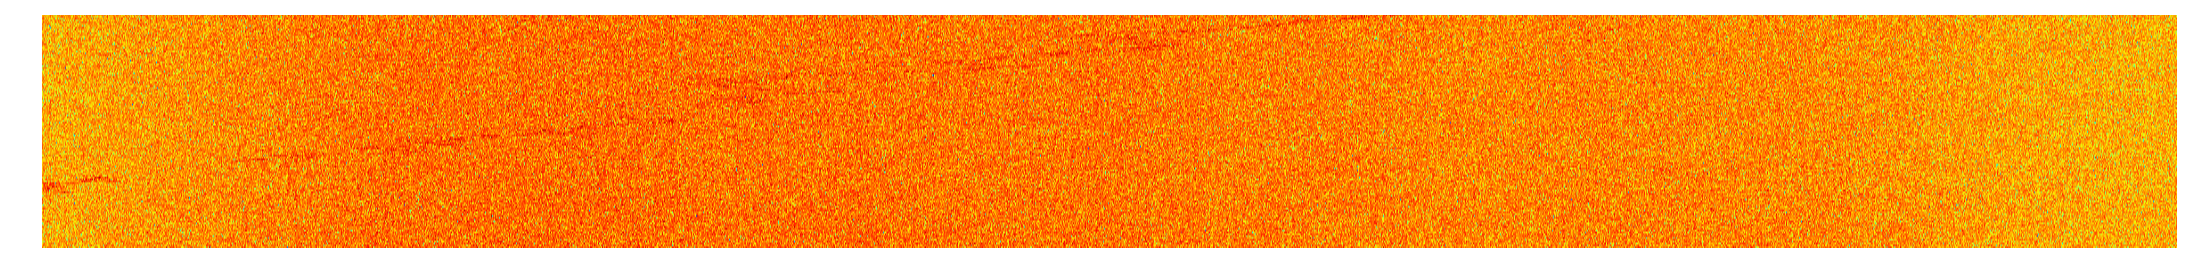

In [49]:
# spec = subsetSpectrograms['narrowband'][1]
# spec = subsetSpectrograms['squiggle'][1]
spec = subsetSpectrograms['squigglesquarepulsednarrowband'][2][1:,:]
generateImageFromSpec(spec,(2048,224),save=True,filename="resized_spec")

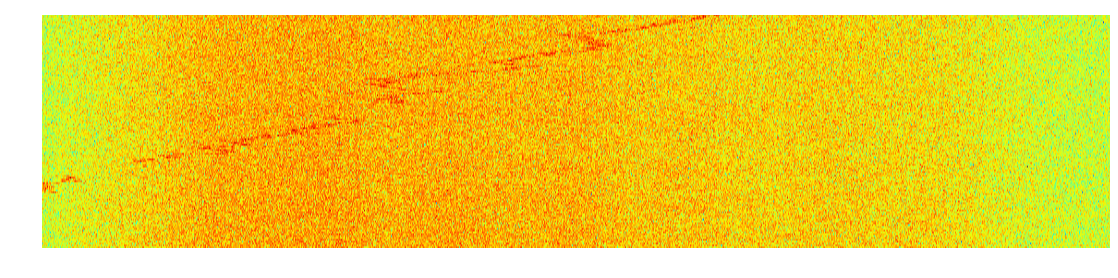

In [50]:
# Using code from https://gist.github.com/derricw/95eab740e1b08b78c03f, reducing along x axis
# Seeing how much file can be reduced in size. Ignoring first row to make it 128x6144
# Then factoring down on x-axis by 3 to 128x2048
spec_reduced_x3 = cu.nputils.bin_ndarray(spec,(128,2048),operation='average')
generateImageFromSpec(spec_reduced_x3,(1024,224),save=True,filename="resized_spec_binned_x3")

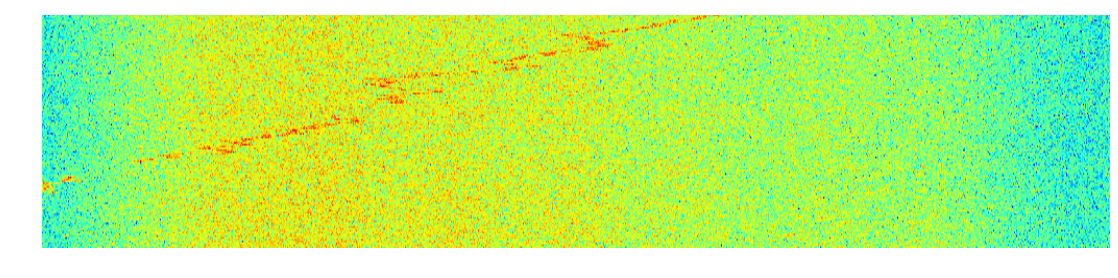

In [51]:
# Using code from https://gist.github.com/derricw/95eab740e1b08b78c03f, reducing along x axis
# Seeing how much file can be reduced in size. Ignoring first row to make it 128x6144
# Then factoring down on x-axis by 6 to 128x1024
spec_reduced_x6 = cu.nputils.bin_ndarray(spec,(128,1024),operation='average')
generateImageFromSpec(spec_reduced_x6,(1024,224),save=True,filename="spec_binned_x6")

## Saving a sample of images - to send to Andreas

In [8]:
subsetSpectrograms.keys()

['noise',
 'squiggle',
 'narrowbanddrd',
 'brightpixel',
 'narrowband',
 'squigglesquarepulsednarrowband',
 'squarepulsednarrowband']

In [22]:
for key in subsetSpectrograms.keys():
    for i in range(len(subsetSpectrograms[key])):
        %%system mkdir -p sampleImages
        spec = subsetSpectrograms[key][i]
        fname = "./sampleImages/{}_{}".format(key,i)
        cu.datautils.saveImageFromSpec(spec,(1024,224),save=True,filename=fname)